# Projeto de Recomendação de filmes usando ML

## Carregar e Analisar os dados

In [1]:
# Bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer

In [2]:
# Definir o caminho dos arquivos
ratings_path = 'ratings.csv'
movies_path = 'movies.csv'

# Criar a pasta "Graficos" se não existir
save_path = 'Graficos'
os.makedirs(save_path, exist_ok=True)

In [3]:
# Definir o caminho dos arquivos
ratings_path = 'ratings.csv'
movies_path = 'movies.csv'

# Carregar os datasets
ratings = pd.read_csv(ratings_path)
movies = pd.read_csv(movies_path)

### Análise inicial

In [23]:
# Exibir as primeiras linhas dos datasets
print("Ratings DataFrame:")
print(ratings.head())

print("\nMovies DataFrame:")
print(movies.head())

# Informações sobre os datasets
print("\nInformações do Ratings DataFrame:")
print(ratings.info())

print("\nInformações do Movies DataFrame:")
print(movies.info())

# Verificando valores ausentes
print("\nValores ausentes no Ratings DataFrame:")
print(ratings.isnull().sum())

print("\nValores ausentes no Movies DataFrame:")
print(movies.isnull().sum())

Ratings DataFrame:
   userId  movieId  rating   timestamp
0       1      296     5.0  1147880044
1       1      306     3.5  1147868817
2       1      307     5.0  1147868828
3       1      665     5.0  1147878820
4       1      899     3.5  1147868510

Movies DataFrame:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  

Informações do Ratings DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000095 entries, 0 to 25000094
Data columns (to

### Análise exploratória adicional

*   Distribuição das avaliações
*   Número de avaliações por filme
*   Número de avaliações por usuário
*   Distribuição dos gêneros

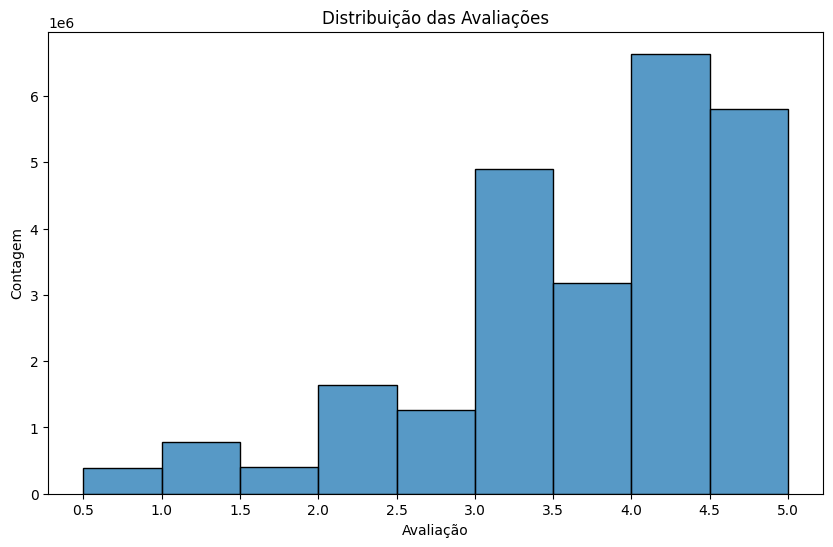

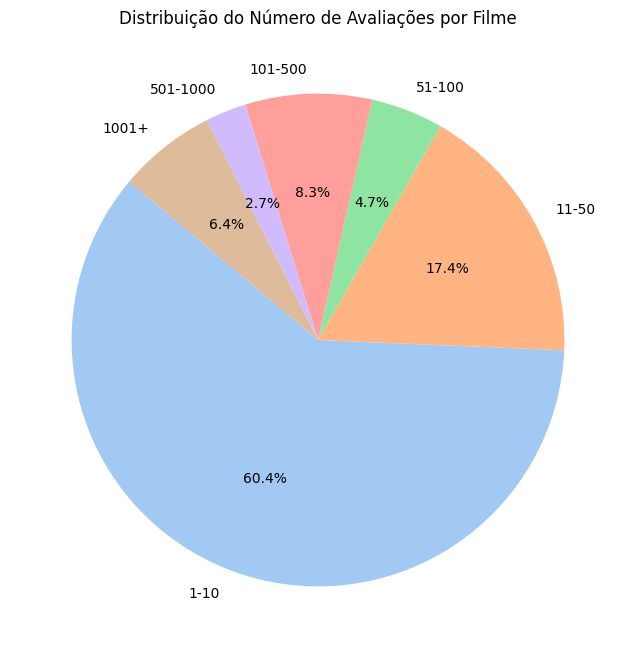

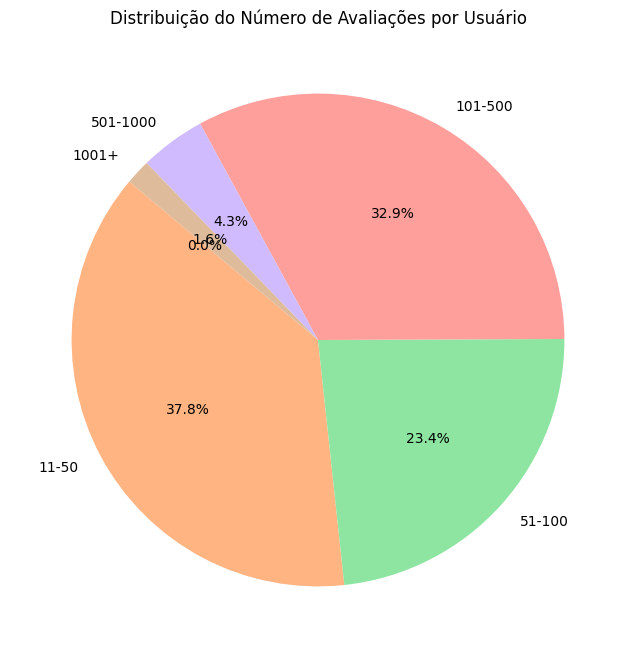

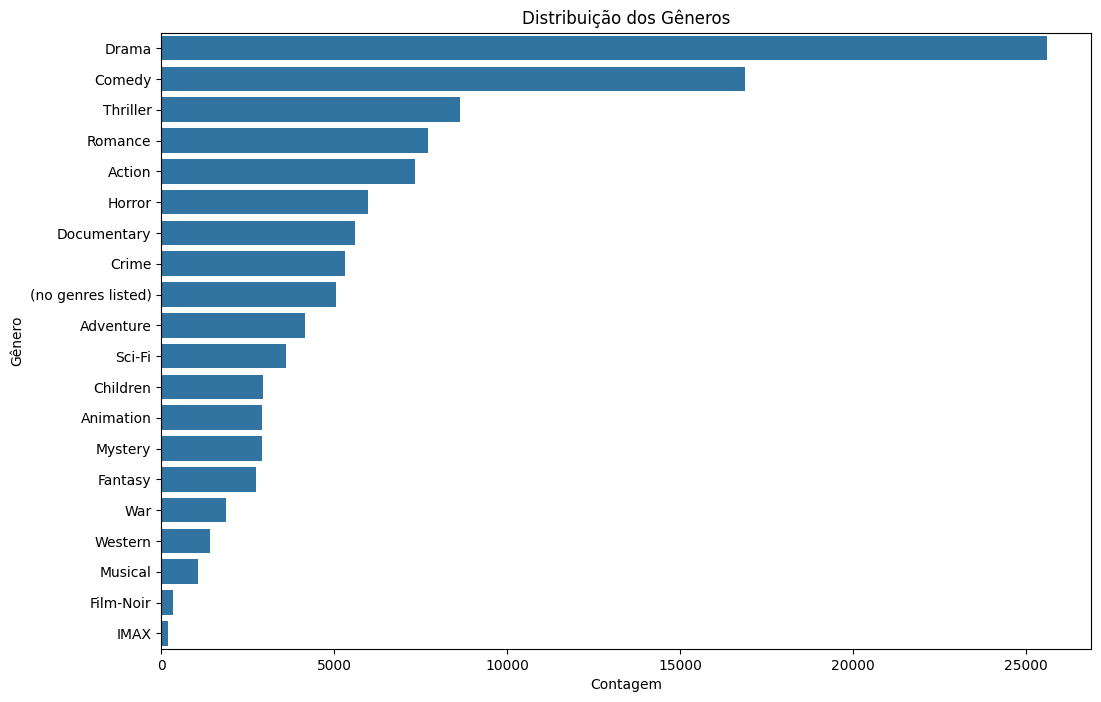

In [24]:
# Definir os intervalos de 0.5 em 0.5
bins = np.arange(0.5, 5.5, 0.5)
# Distribuição das avaliações
plt.figure(figsize=(10, 6))
sns.histplot(ratings['rating'], bins=bins, kde=False)
plt.title('Distribuição das Avaliações')
plt.xlabel('Avaliação')
plt.ylabel('Contagem')
plt.xticks(np.arange(0.5, 5.5, 0.5))  # Definir os ticks do eixo x
plt.savefig(os.path.join(save_path, 'distribuicao_avaliacoes.png'))
plt.show()

# Número de avaliações por filme
ratings_per_movie = ratings.groupby('movieId').size()
bins = [0, 10, 50, 100, 500, 1000, ratings_per_movie.max()]
labels = ['1-10', '11-50', '51-100', '101-500', '501-1000', '1001+']
ratings_per_movie_binned = pd.cut(ratings_per_movie, bins=bins, labels=labels, include_lowest=True)
ratings_per_movie_binned_count = ratings_per_movie_binned.value_counts().sort_index()
plt.figure(figsize=(10, 8))
ratings_per_movie_binned_count.plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title('Distribuição do Número de Avaliações por Filme')
plt.ylabel('')  # Remove o rótulo do eixo Y
plt.savefig(os.path.join(save_path, 'distribuicao_avaliacoes_filme.png'))
plt.show()

# Número de avaliações por usuário
ratings_per_user = ratings.groupby('userId').size()
bins = [0, 10, 50, 100, 500, 1000, ratings_per_user.max()]
labels = ['1-10', '11-50', '51-100', '101-500', '501-1000', '1001+']
ratings_per_user_binned = pd.cut(ratings_per_user, bins=bins, labels=labels, include_lowest=True)
ratings_per_user_binned_count = ratings_per_user_binned.value_counts().sort_index()
plt.figure(figsize=(10, 8))
ratings_per_user_binned_count.plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title('Distribuição do Número de Avaliações por Usuário')
plt.ylabel('')  # Remove o rótulo do eixo Y
plt.savefig(os.path.join(save_path, 'distribuicao_avaliacoes_usuario.png'))
plt.show()

# Distribuição dos gêneros
all_genres = movies['genres'].str.split('|').explode()
plt.figure(figsize=(12, 8))
sns.countplot(y=all_genres, order=all_genres.value_counts().index)
plt.title('Distribuição dos Gêneros')
plt.xlabel('Contagem')
plt.ylabel('Gênero')
plt.savefig(os.path.join(save_path, 'distribuicao_generos.png'))
plt.show()


## Preparação dos Dados

In [4]:
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
from sklearn.preprocessing import MultiLabelBinarizer
from surprise import SVD, Dataset, Reader
from surprise.model_selection import cross_validate
from surprise import accuracy
from sklearn.metrics.pairwise import cosine_similarity
from pyswarm import pso

# Amostragem dos dados de ratings
ratings_sampled = ratings.sample(frac=1/100, random_state=42)
movies_sampled = movies.sample(frac=1/1, random_state=42)

# Verificar o tamanho do DataFrame amostrado
print(f"Tamanho do DataFrame de Ratings amostrado: {ratings_sampled.shape[0]} linhas")

# Dividir em conjunto de treinamento e teste
train_data_sampled, test_data_sampled = train_test_split(ratings_sampled, test_size=0.3, random_state=42)

Tamanho do DataFrame de Ratings amostrado: 250001 linhas


# Implementação

Collaborative Filtering

In [5]:
# Converter o dataframe de ratings amostrado para o formato usado pelo Surprise
reader = Reader(rating_scale=(0.5, 5.0))
train_data_sampled_surprise = Dataset.load_from_df(train_data_sampled[['userId', 'movieId', 'rating']], reader)
test_data_sampled_surprise = Dataset.load_from_df(test_data_sampled[['userId', 'movieId', 'rating']], reader)

# Treinar o modelo SVD apenas com os dados de treinamento
trainset_sampled = train_data_sampled_surprise.build_full_trainset()
svd = SVD()
svd.fit(trainset_sampled)
print('Modelo treinado com sucesso!')

# Prever ratings para o conjunto de teste
testset_sampled = test_data_sampled_surprise.construct_testset(test_data_sampled_surprise.raw_ratings)
predictions_sampled = svd.test(testset_sampled)
print('Previsões feitas com sucesso!')

# Avaliar o modelo
print(accuracy.rmse(predictions_sampled))

Modelo treinado com sucesso!
Previsões feitas com sucesso!
RMSE: 0.9530
0.9529756805835805


## Codificação de gêneros e cálculo de similaridade

In [6]:
# Usar MultiLabelBinarizer para codificar os gêneros
mlb = MultiLabelBinarizer()
movies['genres'] = movies['genres'].apply(lambda x: x.split('|'))
genres_encoded = mlb.fit_transform(movies['genres'])
genres_df = pd.DataFrame(genres_encoded, columns=mlb.classes_)

# Juntar os dados de filmes com a codificação de gêneros
movies_with_genres = pd.concat([movies, genres_df], axis=1)

# Exibir as primeiras linhas para verificar
print(movies_with_genres.head())

# Calcular a similaridade de cosseno entre os filmes
cosine_sim = cosine_similarity(genres_encoded, genres_encoded)
cosine_sim_df = pd.DataFrame(cosine_sim, index=movies['movieId'], columns=movies['movieId'])

   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                              genres  (no genres listed)  \
0  [Adventure, Animation, Children, Comedy, Fantasy]                   0   
1                     [Adventure, Children, Fantasy]                   0   
2                                  [Comedy, Romance]                   0   
3                           [Comedy, Drama, Romance]                   0   
4                                           [Comedy]                   0   

   Action  Adventure  Animation  Children  Comedy  Crime  ...  Film-Noir  \
0       0          1          1         1       1      0  ...          0   
1       0          1          0         1       0      0  ...          0   
2       0     

## Sistema de Recomendação baseada em conteúdo

In [7]:

# Função para recomendar filmes baseada na similaridade
def content_based_recommendations(movie_id, num_recommendations=10):
    sim_scores = cosine_sim_df[movie_id].sort_values(ascending=False)
    sim_scores = sim_scores[1:num_recommendations+1]
    recommended_movies = movies[movies['movieId'].isin(sim_scores.index)]
    return recommended_movies

# Testar a recomendação
print(content_based_recommendations(2))  # Recomendação para o filme com movieId 1


       movieId                                              title  \
10674    44155                        Five Children and It (2004)   
10733    44763  Brothers Lionheart, The (Bröderna Lejonhjärta)...   
23835   119655                                 Seventh Son (2014)   
26665   126937            Journey to the Beginning of Time (1955)   
43660   166556                      Pojken med guldbyxorna (2014)   
43928   167132                                       Perri (1957)   
44134   167580                 Adventures in Dinosaur City (1991)   
54398   189473                        Red, Honest, in Love (1984)   
56151   193539               The Cave of the Golden Rose 5 (1996)   
60789   204162                                Little Ghost (1997)   

                               genres  
10674  [Adventure, Children, Fantasy]  
10733  [Adventure, Children, Fantasy]  
23835  [Adventure, Children, Fantasy]  
26665  [Adventure, Children, Fantasy]  
43660  [Adventure, Children, Fantasy]  


## Execução do SVD sem PSO

In [8]:
# Preparar o dataset para o Surprise
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(test_data_sampled[['userId', 'movieId', 'rating']], reader)

# Função para calcular o RMSE médio
def calculate_rmse(svd, data):
    cv_results = cross_validate(svd, data, measures=['RMSE'], cv=3, verbose=False)
    mean_rmse = np.mean(cv_results['test_rmse'])
    return mean_rmse

# Modelo SVD sem PSO (parâmetros padrão)
svd_default = SVD()
rmse_default = calculate_rmse(svd_default, data)

print('RMSE do modelo padrão (sem PSO):', rmse_default)
 

RMSE do modelo padrão (sem PSO): 0.9873118595607687


## Otimização dos parâmetros do SVD com PSO

In [8]:
# Definir a função objetivo para o PSO
def objective_function(params):
    # Extrair os parâmetros
    n_factors, n_epochs, lr_all, reg_all = params

    # Configurar o modelo SVD com os parâmetros fornecidos
    algo = SVD(n_factors=int(n_factors), n_epochs=int(n_epochs), lr_all=lr_all, reg_all=reg_all)

    # Avaliar o modelo usando validação cruzada
    cv_results = cross_validate(algo, train_data_sampled_surprise, measures=['RMSE'], cv=3, verbose=False)

    # Retornar a média dos RMSEs
    mean_rmse = np.mean(cv_results['test_rmse'])
    return mean_rmse

# Definir os limites para os parâmetros
lb = [10, 10, 0.002, 0.02]
ub = [200, 50, 0.02, 0.2]

# Executar o PSO
optimal_params, optimal_rmse = pso(objective_function, lb, ub, swarmsize=10, maxiter=10)

print('Parâmetros ótimos:', optimal_params)
print('Melhor RMSE:', optimal_rmse)


Stopping search: maximum iterations reached --> 10
Parâmetros ótimos: [1.45983017e+01 4.65127257e+01 5.14224879e-03 1.13479168e-01]
Melhor RMSE: 0.9539557067560082
